In [1]:
from pylab import *
import pandas as pd
from scipy.constants import pi, N_A
from scipy import integrate
from scipy.optimize import curve_fit

import os, sys
sys.path.append(os.path.abspath('../'))

# Constants and Data as Recieved

In [2]:
# electrode geometric area
dia = 1.4 # cm
area = pi*(dia/2)**2 # cm2
# molar mass of FF
MW = 9.608E10 #ng/mol

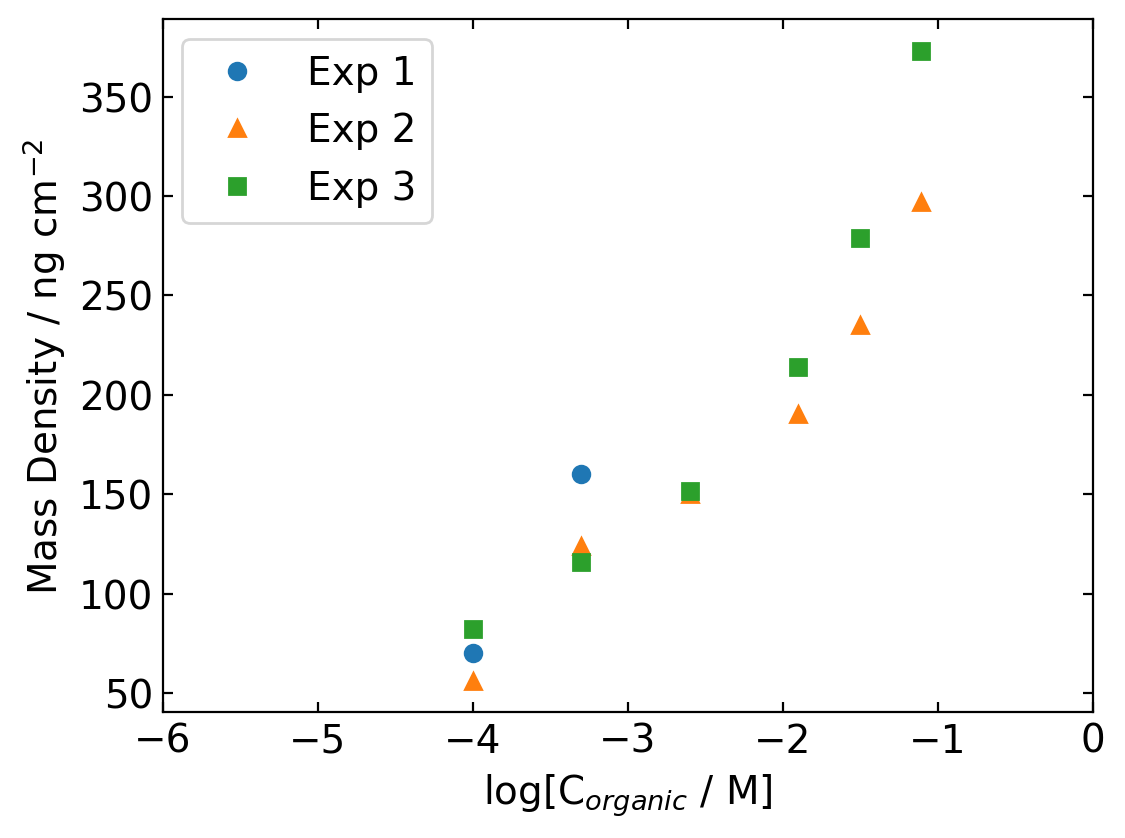

In [3]:
mrks = ['o', '^', 's']
for i in arange(0,3):
    data = pd.read_csv(f'../data/FF_QCM/FF{i+1}.csv')
    # mass density
    md = array(data['Mass density (ng/cm2)'])
    cs = array(data['Concentration (mM)'])*1e-3
    plot(log10(cs),md,f'{mrks[i]}', label = f'Exp {i+1}')
xlabel('log[C$_{organic}$ / M]')
xlim(-6, 0)
ylabel('Mass Density / ng cm$^{-2}$')
#ylim(0,1)
legend()
show()

# Convert to Coverage vs. Concentration data
There is an inflection point where the low concentration data (Concentration less than 0.01 M) appears to come to a plateau. After this point, the mass density increases exponentially. As a result, only the low concentration data will be considered in the fitting.

To convert to theta, a density of surface atoms is needed. An average for polycrystalline Pt is estimated to be 1.31 × 10$^{15}$ cm$^{−2}$ reported in Wei, X.; Reiner, A.; Müller, E.; Wokaun, A.; Scherer, G. G.; Zhang, L.; Shou, K.-Y. .; Nelson, B. J. Electrochemical Surface Reshaping of Polycrystalline Platinum: Morphology and Crystallography. Electrochimica Acta 2007, 53 (11), 4051–4058. https://doi.org/10.1016/j.electacta.2007.08.071. 

In [4]:
# Pt surface atom density from lit
sad = 1.31E15 # atoms/cm2

In [5]:
θs = []
Cs = []
for i in arange(0,3):
    data = pd.read_csv(f'../data/FF_QCM/FF{i+1}.csv')
    # mass density
    md = array(data['Mass density (ng/cm2)'])[:3]
    # number of molecules FF per Pt surface atom
    θ = (md*N_A)/(MW * sad)
    θs.append(θ)
    # concentration in M
    cs = array(data['Concentration (mM)'])[:3]*1e-3
    Cs.append(cs)

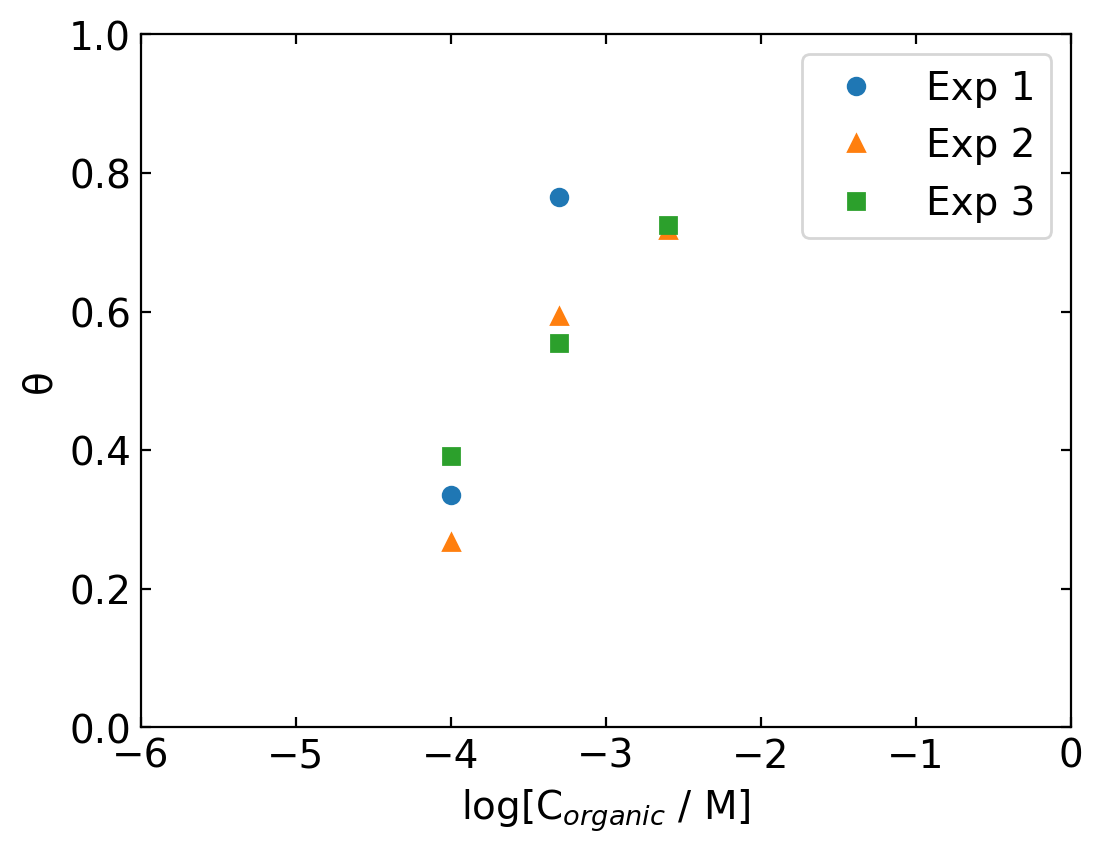

In [6]:
# plot FF coverage vs. FF concentration, excluding zero point
mrks = ['o', '^', 's']
for i,c in enumerate(Cs):
    plot(log10(c), θs[i], f'{mrks[i]}', label = f'Exp {i+1}')
xlabel('log[C$_{organic}$ / M]')
xlim(-6, 0)
ylabel('θ')
ylim(0,1)
legend()
show()

In [7]:
# combine points for one fit
θall = []
Call = []
for i,t in enumerate(θs[0]):
    if i < 2:
        θall += [t,θs[1][i],θs[2][i]]
        Call += [Cs[0][i],Cs[1][i],Cs[2][i]]
    else:
        θall += [θs[1][i],θs[2][i]]
        Call += [Cs[1][i],Cs[2][i]]
θall,Call       

([0.3349227529857434,
  0.2679382023885947,
  0.3923380820690137,
  0.7655377211102706,
  0.5932917338604597,
  0.5550148478049463,
  0.7176916135408786,
  0.7248685296762875],
 [0.0001, 0.0001, 0.0001, 0.0005, 0.0005, 0.0005, 0.0025, 0.0025])

# Calculate $\theta _{sat}$ $\Delta G_{eq,0}^{aq}$ and $\alpha$

## Langmuir Isotherm
$$ \frac{\theta _0}{1-\theta _0}=\frac{C}{C_0} \exp \left[-\frac{\Delta G_{\mathrm{ads, aq}}}{R T}\right] $$

where $\theta _0 = \frac{\theta _{QCM}}{\theta _{sat}}$, $C_0$ = 1 M

## function to fit
$$ \theta _0 =\frac{\frac{C}{C_0} \exp \left[-\frac{\Delta G_{\mathrm{ads, aq}}}{R T}\right]}{1 + \frac{C}{C_0} \exp \left[-\frac{\Delta G_{\mathrm{ads, aq}}}{R T}\right]} $$

In [8]:
# Constants
C0 = 1 # M, standard state concentration
R = 8.314/1000 # kJ/mol*K, gas constant
T = 293 # K, experiment temperature
θ_eval = 1/16

In [9]:
# function for fit
def langmuir(C,θsat,ΔG):
    return θsat * ((C/C0) *  exp((-ΔG)/(R*T))) / (1 + ((C/C0) *  exp((-ΔG)/(R*T))))

In [10]:
fit_data = []
θfit = []
Cfit = []
for i,c in enumerate([Call]):
    popt, pcov = curve_fit(langmuir, c, θall)
    θsat, ΔG0aq = popt
    θserr,G0err = sqrt(diag(pcov))
    Cfit_arr = logspace(-6, 0,100000)
    Cfit.append(Cfit_arr)
    θfit.append(langmuir(Cfit_arr,*popt))
    
    fit_data.append([θsat, θserr, ΔG0aq, G0err, 0, 0])

### Comparison Plot

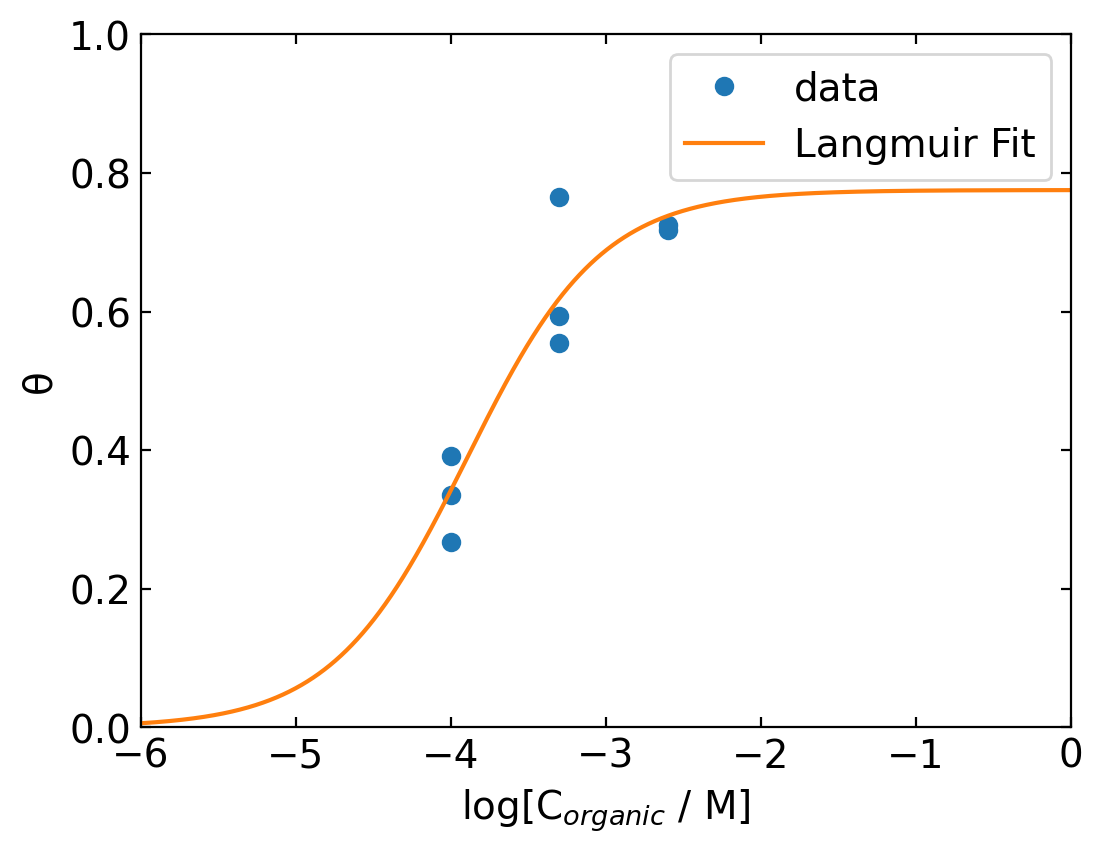

In [11]:
plot(log10(Call), θall,'o', label = 'data')
plot(log10(Cfit[0]), θfit[0], label = 'Langmuir Fit')
xlabel('log[C$_{organic}$ / M]')
xlim(-6, 0)
ylabel('θ')
ylim(0,1)
legend(bbox_to_anchor = (1,1))
show()

## Calculate $\Delta G_{eq,\theta _{eval}}^{aq}$

$$ \Delta G_{eq,\theta _{eval}}^{aq} = \Delta G_{eq,0}^{aq} + \alpha \theta _{eval}$$

In [12]:
aq_data = []
for i,d in enumerate(fit_data):
    θsat, θserr, ΔG0aq, G0err, α, aerr = d
    aq_data.append([θsat, θserr, ΔG0aq, G0err, 0, 0,ΔG0aq, G0err])

# Calculate Gas Phase Free Energies

In [13]:
# Henry's Law constant for FF in water at 25C
# R. Sander: Compilation of Henry's law constants (version 5.0.0) for water as solvent
# Atmos. Chem. Phys., 23, 10901-12440 (2023), doi:10.5194/acp-23-10901-2023
# calculate KH as an average of the database
# KHs = array([2.6, 2.6, 2.7, 2.7, 3.0, 3.0, 9.6, 8.4e-1,1.7,2.0e-1,
       # 6.2,7.8e-1, 3.0, 6.0, 8.1e-1])/100
KHs = array([2.6,2.6,2.7,2.7]) * 100 # bar/M # only vapor pressure/aqueous solubility points
KHav = 1/(average(KHs) * R * 10 * 298) # multiply by RT to be dimensionless, conversion to L*bar/mol*K
# correct for salting out, details in "Salting Out of Furans" note
Ks = 0.06657
KH = KHav / exp(Ks*0.1)
KHerr = std(1/(KHs* R * 10 * 298))

## Calculate dimensionless $K_H$ ($K_{H,dl}$)

$$ K_{H,dl} = K_HRT$$

## Calculate $\Delta G_{eq,0}^{gas}$

$$ K^{gas}_{eq,0} = \frac{K^{aq}_{eq,0}}{K_H} $$

$$ K^{aq}_{eq,0} = exp(\frac{-\Delta G^{aq}_{0}}{RT}) $$

$$ exp(\frac{-\Delta G^{gas}_{0}}{RT}) = \frac{exp(\frac{-\Delta G^{aq}_{0}}{RT})}{K_H} $$

$$ \Delta G_{eq,0}^{gas} = \Delta G_{eq,0}^{aq} + RTln(K_H) $$

## Calculate enthalpies of adsorption from Gibbs free energy

$$ \Delta H = \Delta G + T \Delta S$$

In [14]:
# gas phase entropy from https://data.nist.gov/od/id/mds2-2561
Sgas = 322.457/1000 # kJ/mol*K, ideal gas entropy
# correlation of adsorption entropy to gas phase (Singh 2019 and Campbell 2012)
ΔS = 0.7*Sgas - 3.3*R - Sgas
ΔS

-0.12417330000000001

In [15]:
gas_data = []
for i,a in enumerate(aq_data):
    θsat, θserr, ΔG0aq, G0err, α, aerr,ΔGaq_e, Gerr = a
    ΔHaq = ΔG0aq
    ΔG0gas = ΔG0aq + R*T*log(KH)
    ΔHgas = ΔG0gas + T*ΔS
    G0err_g = sqrt((G0err)**2 + (KHerr*((R*T)/KH))**2)
    ΔGgas_e = ΔG0gas + α*θ_eval 
    ΔHgas_e = ΔGgas_e + T*ΔS
    Gerr_g = sqrt((G0err_g)**2 + (aerr*θ_eval)**2)
    gas_data.append([ΔHaq, ΔG0gas, G0err_g, ΔHgas, ΔGgas_e, Gerr_g, ΔHgas_e])

# Bond Additivity

The following calculations follow the calculations described in N. Singh and C. T. Campbell, "A Simple Bond-Additivity Model Explains Large Decreases in Heats of Adsorption in Solvents Versus Gas Phase: A Case Study with Phenol on Pt(111) in Water", ACS Catal., 9, 8116–8127 (2019). doi:10/ghwfr7

$$ \Delta H_{ads,gas} = H_7 - H_0 = H_{70}$$

$$\Delta H_{ads,aq} = H_6 - H_2 = H_{62}$$

$$\begin{aligned}
\Delta H_{70} & =\Delta H_{62}+\Delta H_{76}+\Delta H_{20} \\
& =\Delta H_{62}+U_{W A}-H_H-U_{W M} \\
& U_{W A}=\frac{1}{2}\left(H_H+U_{W W}\right) \\
\Delta H_{70} & =\Delta H_{62}+\frac{1}{2}\left(H_H+U_{W W}\right)-H_H-U_{W M} \\
& =\Delta H_{62}+0.5 U_{W W}-0.5 H_H-U_{W M}
\end{aligned}$$

In [16]:
# constants
γ = 0.073/1000 # water surface energy, kJ/m2
fp = 3.02E-19*N_A # footprint of furfural from pubchem, m2/mol FF
Eadh = 0.32/1000 # water adhesion energy, kJ/m2
APtfrac = 1/9 # ratio of FF molecules to Pt surface atoms

# second temp data for van't Hoff eq from same database as first KH
T1 = 298 # K
T2 = 373 # K
KH2 = 1/(7.2E-2 * 100 * R * 10 * T2) # KH of volatility

In [17]:
# Enthalpy for FF solvation, kJ/mol FF
Hsol = R*log(KH/KH2)/((1/T1) - (1/T2))
H_H = -Hsol
H_H

41.74402206676566

In [18]:
# water - water bonding energy, kJ/mol FF
UWW = 2*γ*fp
UWW

26.552823038992

In [19]:
# water - FF bonding energy, kJ/mol FF
UWA = (H_H + UWW)/2
UWA

34.14842255287883

In [20]:
# water - Pt bonding energy, kJ/mol FF
# on Pt(111)
UW111 = Eadh/((sad111*1E4)*APtfrac*(1/N_A))
# on Pt(110)
UW110 = Eadh/((sad110*1E4)*APtfrac*(1/N_A))
# on Pt(100)
UW100 = Eadh/((sad100*1E4)*APtfrac*(1/N_A))
UW111, UW110, UW100

NameError: name 'sad111' is not defined

# Calculate the gas adsorption enthalpy $\Delta H_{70}$
$\Delta H_{70} =\Delta H_{62}+0.5 U_{W W}-0.5 H_H-U_{W M} $

In [ ]:
# aqueous enthalpy of adsorption from exp
ΔH = gas_data[0][0]

In [ ]:
ΔH_111 = ΔH + 0.5*UWW - 0.5*H_H - UW111
ΔH_110 = ΔH + 0.5*UWW - 0.5*H_H - UW110
ΔH_100 = ΔH + 0.5*UWW - 0.5*H_H - UW100
ΔH_111, ΔH_110, ΔH_100

# Summary

In [ ]:
param_name = ['K_H','ΔGad_aq_θ0', 'ΔHad_aq_θ0','ΔGad_gas_θ0', 'ΔHad_gas_θ0','α', 'θsat', 
              'θeval', 'ΔGad_aq_θeval', 'ΔGad_gas_θeval','ΔHad_gas_θeval',
              'ΔHad_gas_Pt111','ΔHad_gas_Pt110','ΔHad_gas_Pt100']
param_units = [' ','kJ/mol', 'kJ/mol','kJ/mol', 'kJ/mol',None, None, 
              None, 'kJ/mol', 'kJ/mol','kJ/mol','kJ/mol','kJ/mol','kJ/mol']

In [ ]:
param_vals, param_errs = [],[]
for i,a in enumerate(aq_data):
    θsat, θserr, ΔG0aq, G0err, α, aerr,ΔGaq_e, Gerr = a
    ΔHaq, ΔG0gas, G0err_g, ΔHgas, ΔGgas_e, Gerr_g, ΔHgas_e = gas_data[i]

    param_vals.append([KH, ΔG0aq, ΔHaq, ΔG0gas , ΔHgas, α , θsat, 
             θ_eval, ΔGaq_e, ΔGgas_e, ΔHgas_e,ΔH_111, ΔH_110, ΔH_100])
    param_errs.append([KHerr, G0err, G0err, G0err_g, G0err_g, aerr, θserr, 
             None, Gerr, Gerr_g,Gerr_g,Gerr_g,Gerr_g,Gerr_g])

In [ ]:
# save parameter data
params = {'Parameter' : param_name,
             'Units' : param_units}

params['Value'] = param_vals[0]
params['Error'] = param_errs[0]

params = pd.DataFrame(params)
params